# Data Preparation

In [7]:
pip install trilabytepyml --upgrade

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd

pd.options.mode.chained_assignment = None

frame = pd.read_csv('retail_unit_demand.csv')
display(frame)

,SKU,STORE_NUMBER,CAL_YEAR,CAL_MONTH,CAL_DATE,UNIT_DEMAND,PREDICTOR_1,PREDICTOR_2,PREDICTOR_3,PREDICTOR_4
0,1100,1150,2016,3,3/1/2016,16.0,1.856107,4.916073,6.350111,0.170545
1,1100,1150,2016,4,4/1/2016,28.0,9.803075,5.647253,40.128298,0.190157
2,1100,1150,2016,5,5/1/2016,35.0,3.598739,15.927959,29.807851,0.006683
3,1100,1150,2016,6,6/1/2016,129.0,1.155522,48.465667,17.236057,0.007743
4,1100,1150,2016,7,7/1/2016,179.0,9.673028,6.603080,39.144862,0.230874
...,...,...,...,...,...,...,...,...,...,...
113,1733,993243,2019,8,8/1/2019,NaN,5.563396,13.576681,12.819330,0.038417
114,1733,993243,2019,9,9/1/2019,NaN,6.663194,43.053491,11.374827,0.144381
115,1733,993243,2020,10,10/1/2020,NaN,2.270636,29.233220,59.000652,0.288833
116,1733,993243,2020,11,11/1/2020,NaN,4.903307,49.802078,27.008816,0.017463


# Forecast Options

In [9]:
options = dict()
options['method'] = 'Auto' #'Auto','MLR','ARIMA'
options['sortColumns'] = ['SKU','STORE_NUMBER','CAL_YEAR','CAL_MONTH']
options['splitColumns'] = ['SKU','STORE_NUMBER']
options['predictorColumns'] = ['PREDICTOR_1','PREDICTOR_2','PREDICTOR_3','PREDICTOR_4']
options['targetColumn'] = 'UNIT_DEMAND'
options['timestampColumn'] = 'CAL_DATE' #only needed by Prophet model  
options['periodicity'] = 12
options['autoDetectOutliers'] = True
options['outlierStdevMultiplier'] = 3.0
options['seasonalityBandwidth'] = 0.6
options['scalePredictors'] = True # MLR only; if true X_COEFFICIENTS become variable importances
options['ridgeAlpha'] = 1.0
options['forceNonNegative'] = True
options['seasonality'] = 'Auto' #'Auto','Additive','Multiplicative'
options['hypertune'] = False
options['numHoldoutRows'] = 6 # how may rows are used for holdout (MAPE calculation)

# Visualizations (first frame only)

In [10]:
# limit data to first combination (so that visualizations below work)
firstFrame = frame[frame['SKU'] == 1100].dropna()

C:\Users\smutc\anaconda3\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


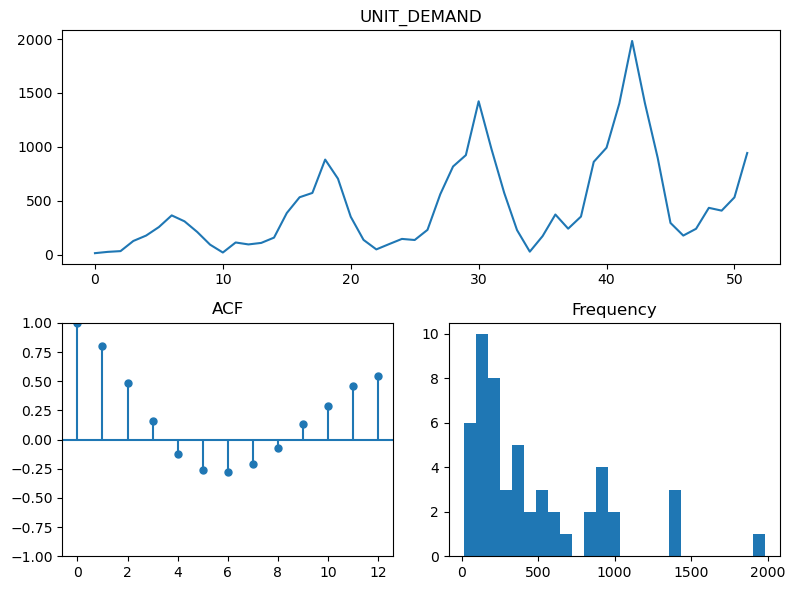

In [11]:
import pmdarima as pm

# Time Series Plot, ACF Plot and Histogram of Frequency
pm.tsdisplay(firstFrame[options['targetColumn']], lag_max=options['periodicity'], title=options['targetColumn'], show=True) 

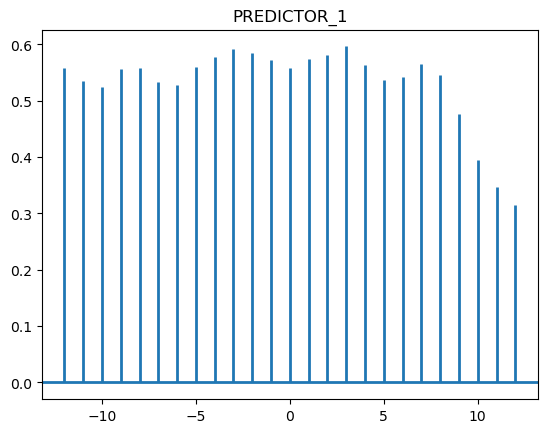

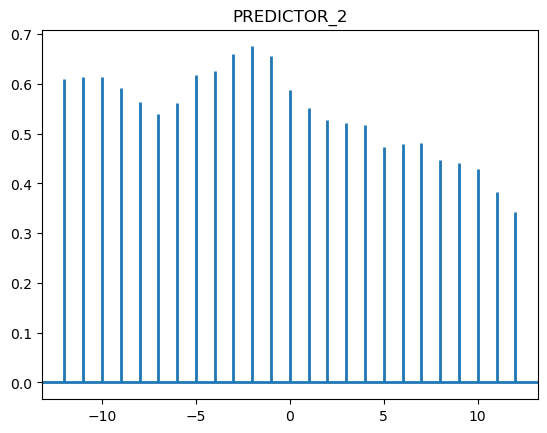

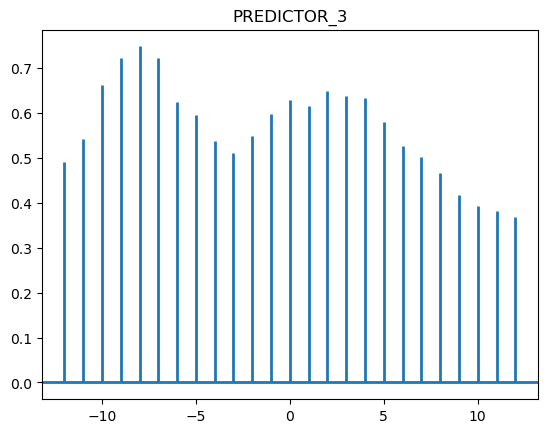

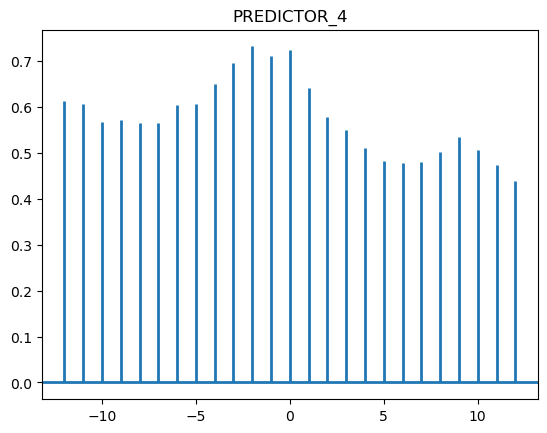

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for predCol in options['predictorColumns']:
    if (predCol != 'X_INDEX'):
        plt.xcorr(firstFrame[predCol], firstFrame[options['targetColumn']], usevlines=True, maxlags=options['periodicity'], normed=True, lw=2)
        plt.title(predCol)
        plt.show()

In [13]:
import seaborn as sns

def cross_correlation_heatmap(cc_df):
    # Credit to Bibor Szabo
    # https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
    
    plt.figure(figsize=(16, 6))

    mask = np.triu(np.ones_like(cc_df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(cc_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Cross Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
    plt.savefig('cc_heatmap.png', dpi=300, bbox_inches='tight')
       
    return()

C:\Users\smutc\AppData\Local\Temp\ipykernel_7172\2529057408.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cc_df.corr(), dtype=np.bool))


()

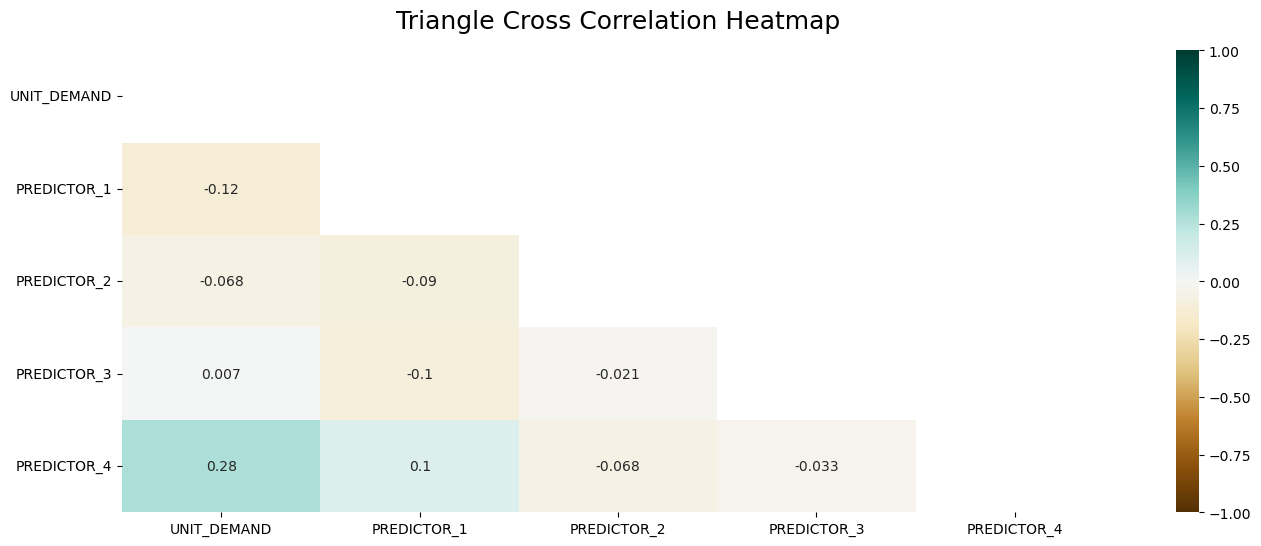

In [14]:
all_vars = [options['targetColumn']] + options['predictorColumns']
if ('X_INDEX' in all_vars):
    all_vars.remove('X_INDEX')
cross_correlation_heatmap(firstFrame[all_vars])

# Forecast Generation

In [15]:
import trilabytepyml.AutoForecast as af

frame = af.splitFramesAndForecast(frame, options)

display(frame)

Auto MAPEs (MLR, ARIMA, Ensemble):  [21.60201233271356, 34.16260893002761, 23.531064345837294]
Auto MAPEs (MLR, ARIMA, Ensemble):  [28.151900134010575, 244.7233548218142, 110.71916169887115]


C:\Users\smutc\anaconda3\lib\site-packages\trilabytepyml\AutoForecast.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputFrame = frame if outputFrame is None else outputFrame.append(frame, ignore_index=True)


,SKU,STORE_NUMBER,CAL_YEAR,CAL_MONTH,CAL_DATE,UNIT_DEMAND,PREDICTOR_1,PREDICTOR_2,PREDICTOR_3,PREDICTOR_4,...,X_SEASONALITY,X_SEASONALITY_TYPE,X_FORECAST,X_MAPE,X_RESIDUAL,X_LPI,X_UPI,X_APE,X_ERROR,X_METHOD
0,1100,1150,2016,3,3/1/2016,16.0,1.856107,4.916073,6.350111,0.170545,...,-230.411691,Additive,0.000000,21.602012,-66.726792,0.000000,287.905276,417.042449,None,MLR
1,1100,1150,2016,4,4/1/2016,28.0,9.803075,5.647253,40.128298,0.190157,...,-243.085106,Additive,0.000000,21.602012,-88.427117,0.000000,278.204950,315.811133,None,MLR
2,1100,1150,2016,5,5/1/2016,35.0,3.598739,15.927959,29.807851,0.006683,...,-178.575957,Additive,10.468903,21.602012,-24.531097,0.000000,349.100971,70.088848,None,MLR
3,1100,1150,2016,6,6/1/2016,129.0,1.155522,48.465667,17.236057,0.007743,...,95.190787,Additive,287.879408,21.602012,158.879408,0.000000,626.511476,123.162332,None,MLR
4,1100,1150,2016,7,7/1/2016,179.0,9.673028,6.603080,39.144862,0.230874,...,273.103398,Additive,488.215028,21.602012,309.215028,149.582960,826.847095,172.745825,None,MLR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1733,993243,2019,8,8/1/2019,NaN,5.563396,13.576681,12.819330,0.038417,...,2.002330,Multiplicative,1479.973727,28.151900,NaN,1291.667302,1668.280151,NaN,None,MLR
114,1733,993243,2019,9,9/1/2019,NaN,6.663194,43.053491,11.374827,0.144381,...,2.772243,Multiplicative,2067.360867,28.151900,NaN,1879.054442,2255.667291,NaN,None,MLR
115,1733,993243,2020,10,10/1/2020,NaN,2.270636,29.233220,59.000652,0.288833,...,2.144319,Multiplicative,1580.938920,28.151900,NaN,1392.632495,1769.245344,NaN,None,MLR
116,1733,993243,2020,11,11/1/2020,NaN,4.903307,49.802078,27.008816,0.017463,...,1.092417,Multiplicative,814.079628,28.151900,NaN,625.773203,1002.386053,NaN,None,MLR


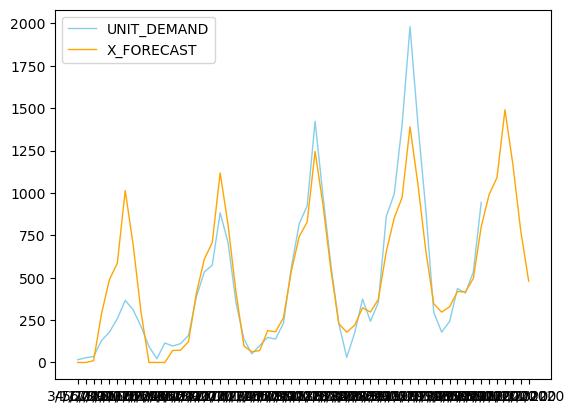

In [16]:
firstFrame = frame[frame['SKU'] == 1100]


plt.plot(options['timestampColumn'],options['targetColumn'], data=firstFrame, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=1)
plt.plot(options['timestampColumn'],'X_FORECAST', data=firstFrame, marker='', markerfacecolor='orange', markersize=12, color='orange', linewidth=1)
plt.legend()

In [17]:
frame.to_csv('output.csv')